## This Part is executed after we save our tweets in databases and perform our sentiment analysis. 

<p>
Having our tweets classified as possitive - negative - neutral we have to get some results and mainly the percentage of them.
    <br> We found it useful after we calculate the results to store them in a <b> new table </b> called <b> Metrics. </b>
</p>

<p>
Furthermore we want to compare the general data with the following: 
   <br> 1) With tweets of users with followers more than 200 people.  </br>
     <br> 2) With only one tweet by a user </br>
</p>
<p>
Thus we  create <b> 2 new tables </b> called <b> Metricsf </b> and <b>Metricsu. </b>

</p>  

<p>
<h3> Afterwards that we create 2 Functions. </h3>
         <br/> 1) To Get the Metrics. In this case we insert two values: 
            <br/> a) the name of the table from which we want to get the data   
            <br/> b) the usage of the data: <b>'all'</b> for General | <b>'fol'</b> for Followers | <b>'uni'</b> for Uniques
  </p>   
<p>
          <br/> 2) Plot the Graphs. In this case we insert the same two values

</p>  

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import mysql.connector

In [2]:
#Since only the 3 tables exist in our database we get a list of them. 

db = mysql.connector.connect(host='localhost', database='tweets', user='root', password= 'alex2611', auth_plugin='mysql_native_password') 
if db.is_connected():
    print("CONNECTED TO MYSQL DATABASE!") 
    cur = db.cursor()
    
q = """SHOW TABLES"""
cur.execute(q)
results = cur.fetchall()
tables_list = [item[0] for item in results] # Conversion to list of str

CONNECTED TO MYSQL DATABASE!


In [3]:
tables_list

['Bucks', 'Celtics', 'Lakers']

In [4]:
#create a table to get the general metrics from the tables

q = "CREATE TABLE Metrics (id int AUTO_INCREMENT, keyword VARCHAR(50), positive_count INT, negative_count INT, neutral_count INT, positive INT, negative INT, neutral INT, PRIMARY KEY (id));"
cur.execute(q)

In [5]:
#create a table to get metrics of people with more that 200 follower

q = "CREATE TABLE Metricsf (id int AUTO_INCREMENT, keyword VARCHAR(50), positive_count INT, negative_count INT, neutral_count INT, positive INT, negative INT, neutral INT, PRIMARY KEY (id));"
cur.execute(q)

In [6]:
#create a table to get the metrics of unique users

q = "CREATE TABLE Metricsu (id int AUTO_INCREMENT, keyword VARCHAR(50), positive_count INT, negative_count INT, neutral_count INT, positive INT, negative INT, neutral INT, PRIMARY KEY (id));"
cur.execute(q)

In [7]:
def GetMetrics (table, use):
    
    tablename = table
    usage = use
    
    #connect to the database
    db = mysql.connector.connect(host='localhost', database='tweets', user='root', password= 'alex2611', auth_plugin='mysql_native_password') 
    if db.is_connected():
        print("CONNECTED TO MYSQL DATABASE!") 
        cur = db.cursor()
    
    #Get the texts from Database for analysis based on the usage

    if usage == 'all':
        
        ttable =  'Metrics'
        q= "SELECT sentiment FROM {}".format(tablename)
        cur.execute(q)
        
    elif usage == 'fol':
        
        ttable =  'Metricsf'
        q= "SELECT sentiment FROM {} where followers > 200".format(tablename)
        cur.execute(q)
    
    else:
        
        ttable =  'Metricsu'
        q= "SELECT sentiment FROM (select user_name, sentiment, row_number() over(partition by user_name order by sentiment) rn from {}) tmp where rn = 1;".format(tablename)
        cur.execute(q)
    
    
    #append them on a list after converting them to strings
    sentiment_results = []

    for result in cur:
        str = ''.join(result)
        sentiment_results.append(str)
    
    #function for the percentage of the results
    def percentage(part,whole):
     return 100 * float(part)/float(whole)

    #START OF ANALYSIS
    #insert variables
    positive = 0
    positive_count = 0
    negative = 0
    negative_count = 0
    neutral = 0
    neutral_count = 0
    
    for i in range(len(sentiment_results)):
                
        if sentiment_results[i] ==  'negative':
            negative_count += 1
            

        elif sentiment_results[i] ==  'positive':
            positive_count += 1

        else:
            neutral_count += 1

       
    #make the calculations of the metrics
    positive = percentage(positive_count, len(sentiment_results))
    negative = percentage(negative_count, len(sentiment_results))
    neutral = percentage(neutral_count, len(sentiment_results))

    positive = format(positive, '.1f')
    negative = format(negative, '.1f')
    neutral = format(neutral, '.1f')

     #append the result of each tweet analysis on the table
    q = "INSERT INTO {} (keyword, positive_count, negative_count, neutral_count, positive, negative, neutral) VALUES (%s, %s, %s, %s, %s, %s, %s)".format(ttable)
    cur.execute(q, (tablename, positive_count, negative_count, neutral_count, positive, negative, neutral))        
    db.commit()
     
    db.close()

In [8]:
def GeneralPlots (key, use):
    
    keyword = key
    usage = use
    
    if usage == 'all': 
        ttable =  'Metrics'
        
    elif usage == 'fol':
        ttable =  'Metricsf'
        
    else:
        ttable =  'Metricsu'
        
    #connect to the database
    db = mysql.connector.connect(host='localhost', database='tweets', user='root', password= 'alex2611', auth_plugin='mysql_native_password') 
    if db.is_connected():
        cur = db.cursor()
        
    #Get the texts from Database for  analysis
    q= "SELECT positive_count, negative_count, neutral_count, positive, negative, neutral FROM {} WHERE keyword like '{}';".format(ttable, keyword)
    cur.execute(q)
    
    # Append the data we got from to new variables
    for positive_count, negative_count, neutral_count, positive, negative, neutral in cur:

        positive_count = positive_count
        negative_count = negative_count
        neutral_count = neutral_count
        positive = positive #percentage
        negative = negative #percentage
        neutral = neutral #percentage
        
    plt.rcParams["figure.figsize"] = (18,8)
    figure, (ax1,ax2) = plt.subplots(1, 2)
    plt.rcParams.update({'font.size': 15})


    y1 = np.array([positive, negative, neutral])
    mylabels1 = ["positive", "negative", "neutral"]

    ax1.pie(y1, labels = mylabels1, autopct='%1.0f%%', pctdistance=0.4, labeldistance=1.2)
    a = ('{} - Percentage Reviews').format(keyword)
    ax1.set_title(a)

    x2 = np.array(["positive", "negative", "neutral"])
    y2 = np.array([positive_count, negative_count, neutral_count])

    ax2.bar(x2,y2)
    b=('{} -  Number of Reviews by Category').format(keyword)
    ax2.set_title(b)


    plt.show()
    
    db.close()


## Get the Metrics

In [9]:
#Get the metrics for general data
for table in tables_list: 
    GetMetrics (table, 'all')

CONNECTED TO MYSQL DATABASE!
CONNECTED TO MYSQL DATABASE!
CONNECTED TO MYSQL DATABASE!


In [10]:
#Get the metrics for users with followers > 200
for table in tables_list: 
    GetMetrics (table, 'fol')

CONNECTED TO MYSQL DATABASE!
CONNECTED TO MYSQL DATABASE!
CONNECTED TO MYSQL DATABASE!


In [11]:
#Get the metrics for posts of unique users
for table in tables_list: 
    GetMetrics (table, 'uni')

CONNECTED TO MYSQL DATABASE!
CONNECTED TO MYSQL DATABASE!
CONNECTED TO MYSQL DATABASE!


## Plots

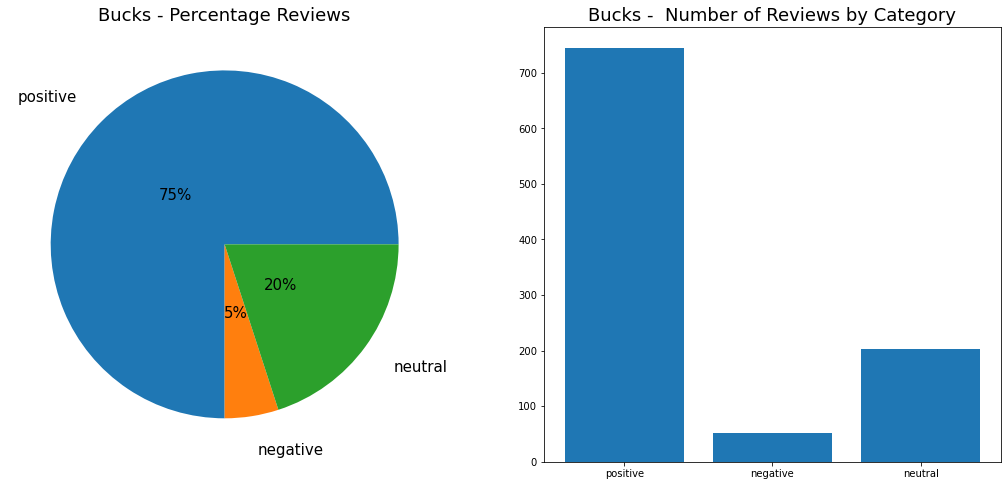

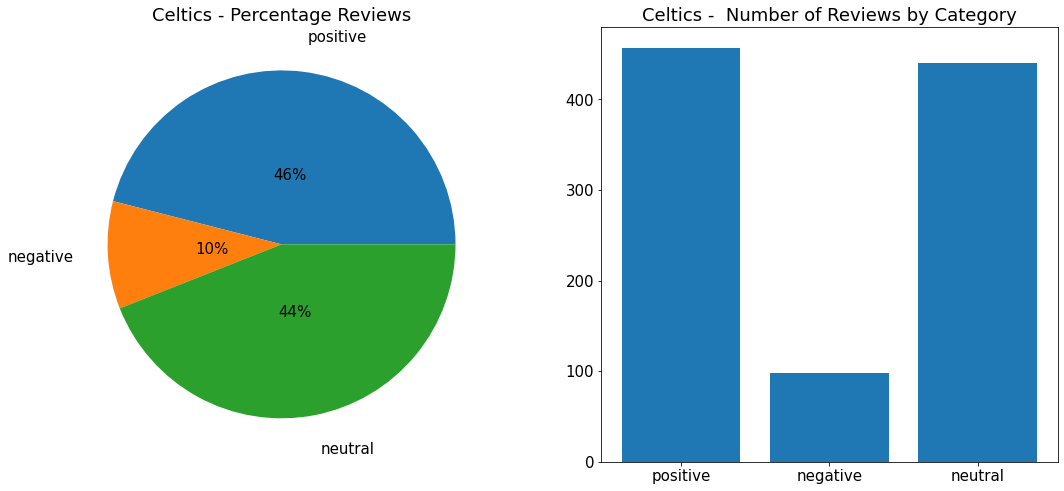

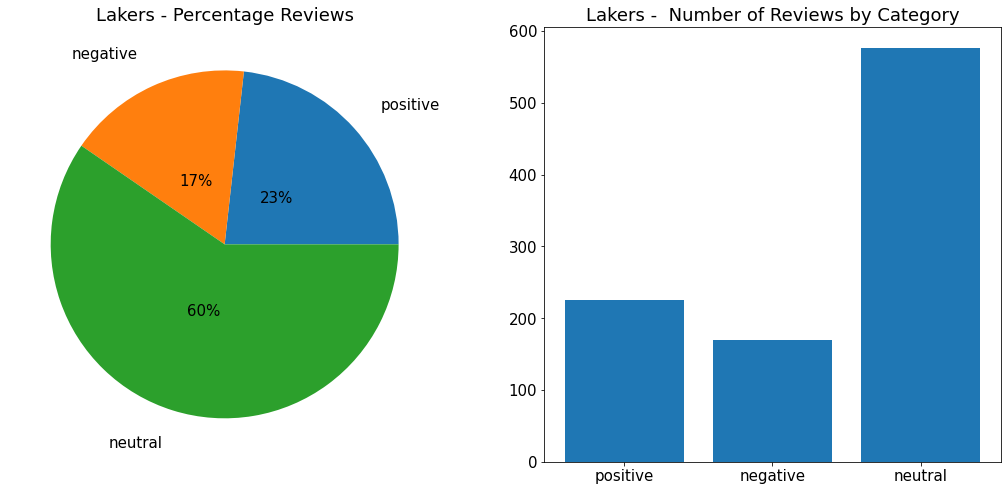

In [12]:
#Plots for general data
for table in tables_list: 
    GeneralPlots (table, 'all')

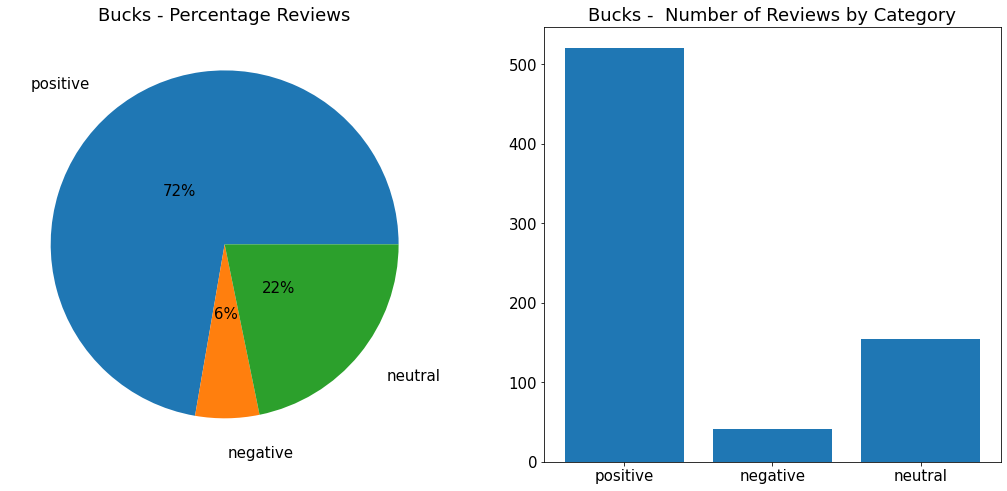

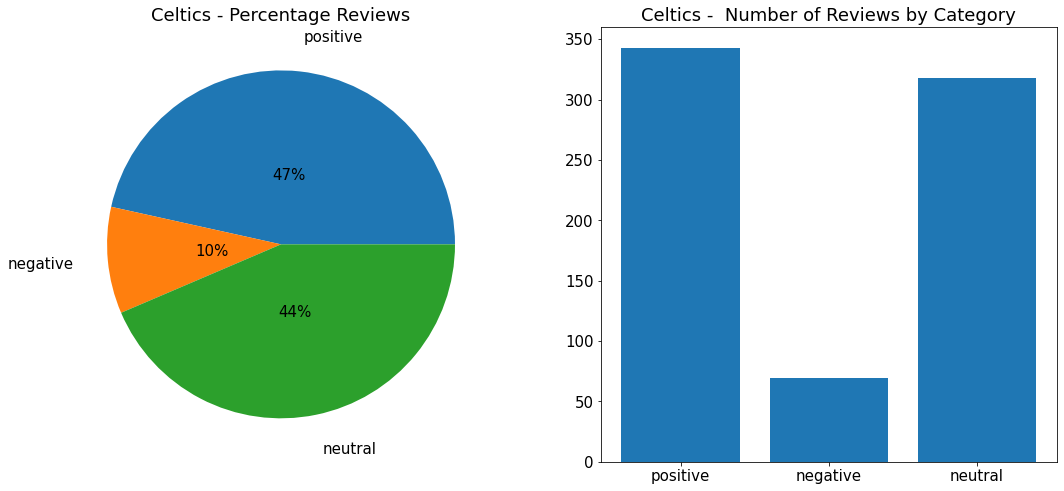

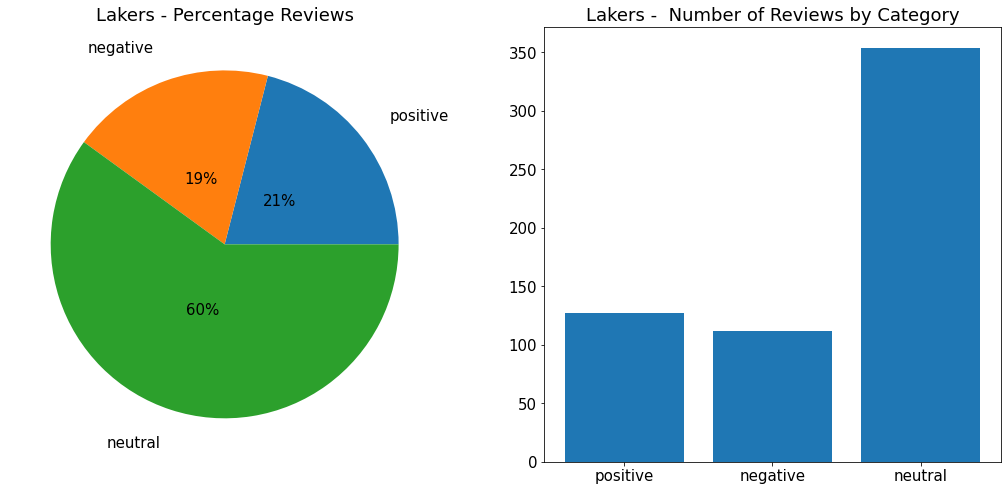

In [13]:
#Plot the metrics for users with followers > 200
for table in tables_list: 
    GeneralPlots (table, 'fol')

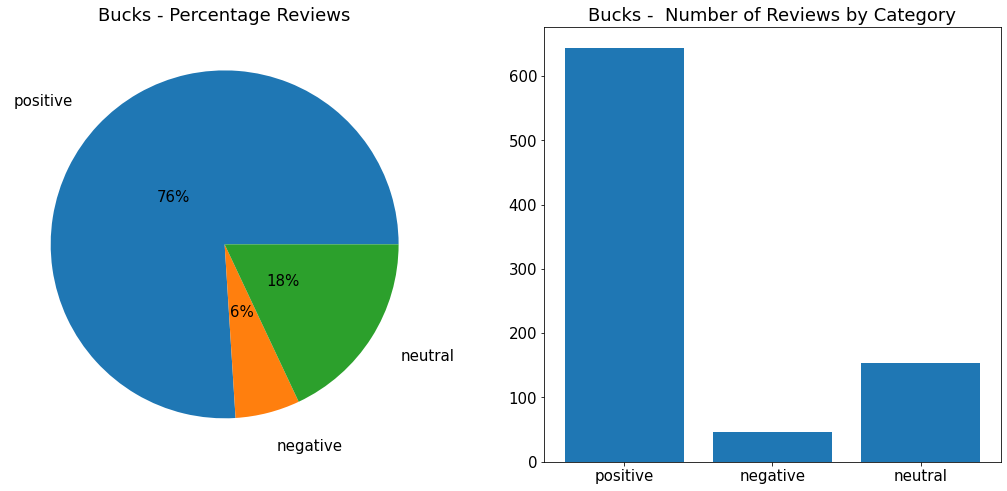

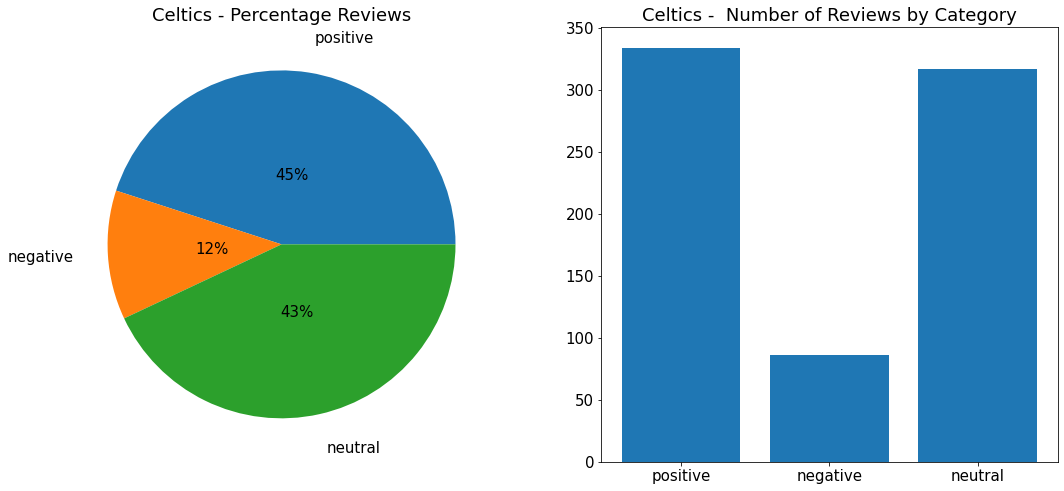

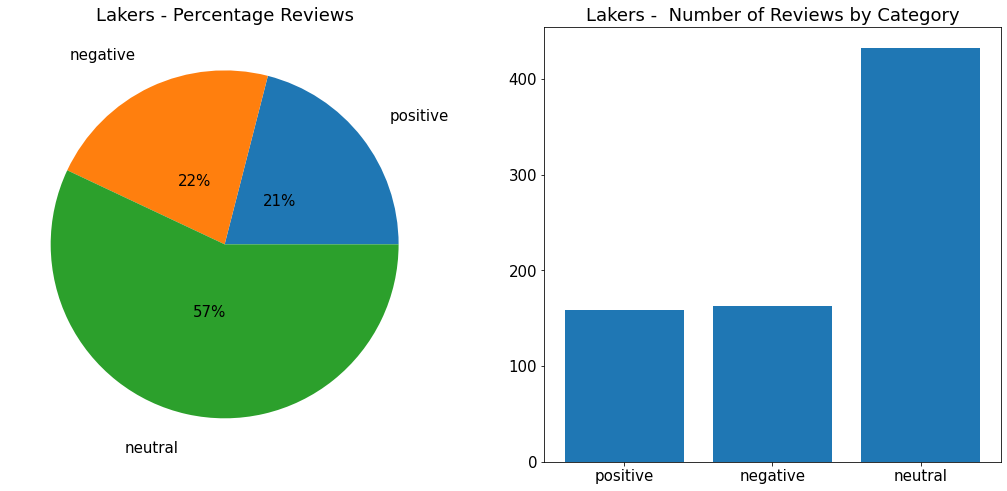

In [14]:
#Plot the metrics for unique users
for table in tables_list: 
    GeneralPlots (table, 'uni')